In [14]:
config_path = './results/f32f45_angular8_zoom_pad_2048_all/config.yaml'
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import src.ASM as ASM
import src.math_tool as mt
import src.img_tool as it
from PIL import Image
import yaml
import src.apertures as apertures
from box import Box
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
time_string = datetime.now().isoformat(timespec='minutes')
################################################## all code in unit of μm
config = None
with open(config_path, 'r') as f:
    config = Box(yaml.safe_load(f))
π, λ = np.pi, eval(config.simulation.λ)
k = 2*π/λ
# simulation config
s_res = config.simulation.resolution
s_x_start, s_x_end, s_y_start, s_y_end, s_z_start, s_z_end = tuple(config.simulation.range)
s_Lx, s_Ly, s_Lz = s_x_end - s_x_start, s_y_end - s_y_start, s_z_end - s_z_start
s_Nx, s_Ny, s_Nz = eval(s_res[0]), eval(s_res[1]), eval(s_res[2]) # manufactured aperture have resolution of 1000 * 1000
s_xs, s_ys, s_zs = np.linspace(s_x_start, s_x_end, s_Nx, endpoint=False), np.linspace(s_y_start, s_y_end, s_Ny, endpoint=False), np.linspace(s_z_start, s_z_end, s_Nz, endpoint=False)
z_batch_size = eval(config.simulation.z_batch_size)

# plot config
x_start, x_end, y_start, y_end= np.array(tuple(config.save.range))
z_start, z_end = s_z_start, s_z_end
xs, ys, zs = s_xs[(x_start <= s_xs)*(s_xs <= x_end)], s_ys[(y_start <= s_ys)*(s_ys <= y_end)], s_zs
x_start, x_end, y_start, y_end = xs[0], xs[-1], ys[0], ys[-1]
Δx, Δy, Δz = xs[1]-xs[0], ys[1]-ys[0], zs[1]-zs[0]
Nx, Ny, Nz = len(xs), len(ys), len(zs)
Nx_ticks, Ny_ticks, Nz_ticks = tuple(config.plot.N_ticks)
x_ticks, y_ticks, z_ticks = np.arange(0, Nx, Nx/Nx_ticks, dtype=int), np.arange(0, Ny, Ny/Ny_ticks, dtype=int), np.arange(0, Nz, Nz/Nz_ticks, dtype=int)
xy_range_index = (np.argwhere(s_xs==x_start).flatten()[0], np.argwhere(s_xs==x_end).flatten()[0], np.argwhere(s_ys==y_start).flatten()[0], np.argwhere(s_ys==y_end).flatten()[0])
save_path = f'{config.path.results}'
save_path_E2 = f'{config.path.E2}'
print(f'memory spike: {z_batch_size * s_Nx * s_Ny * 2 * 128 / 8 / 1024**3}GB') # *2 because np fft is not in-place operation
print(f'simulation size: s_Nx={s_Nx}, s_Ny={s_Ny}, s_Nz={s_Nz}\nfloat32 (intensity) requirement: {Nx * Ny * Nz * 32 / 8 / 1024 / 1024 / 1024} GB\nz-resolution: {(s_z_end - s_z_start)/s_Nz}μm\nconfig file: {config_path}')
#A_xy = np.load(f'{config.path.aperture}')
A_xy = it.img_2_array(config.path.aperture)
if (np.array([s_Nx, s_Ny]) != np.array(A_xy.shape)).any():
    print('error: loaded aperture dimension mismatch')
    exit()
# plt.imshow(A_xy.T, cmap='plasma')
# plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
memory spike: 4.0GB
simulation size: s_Nx=2048, s_Ny=2048, s_Nz=10000
float32 (intensity) requirement: 2.4605169892311096 GB
z-resolution: 10.0μm
config file: ./results/f32f45_angular8_zoom_pad_2048_all/config.yaml


In [ ]:
# compute
time_s = datetime.now()
ASM.ASM_3D_batch_E2_Multi_Process(A_xy, s_Lx, s_Ly, s_zs, λ, save_path_E2, z_batch_size, xy_range_index, num_process=11)
time_e = datetime.now()
print(f'last run: {time_e.isoformat(timespec='minutes')}')
print(f'duration: {time_e - time_s}')

In [15]:
# extract
E2 = ASM.batch_E2_extract(Nx, Ny, Nz, save_path_E2, z_batch_size)
time_e = datetime.now()
print(f'last run: {time_e.isoformat(timespec='minutes')}')

extracting:   0%|          | 0/313 [00:00<?, ?it/s]

extracting: 100%|██████████| 313/313 [00:23<00:00, 13.59it/s]

last run: 2025-08-13T01:34


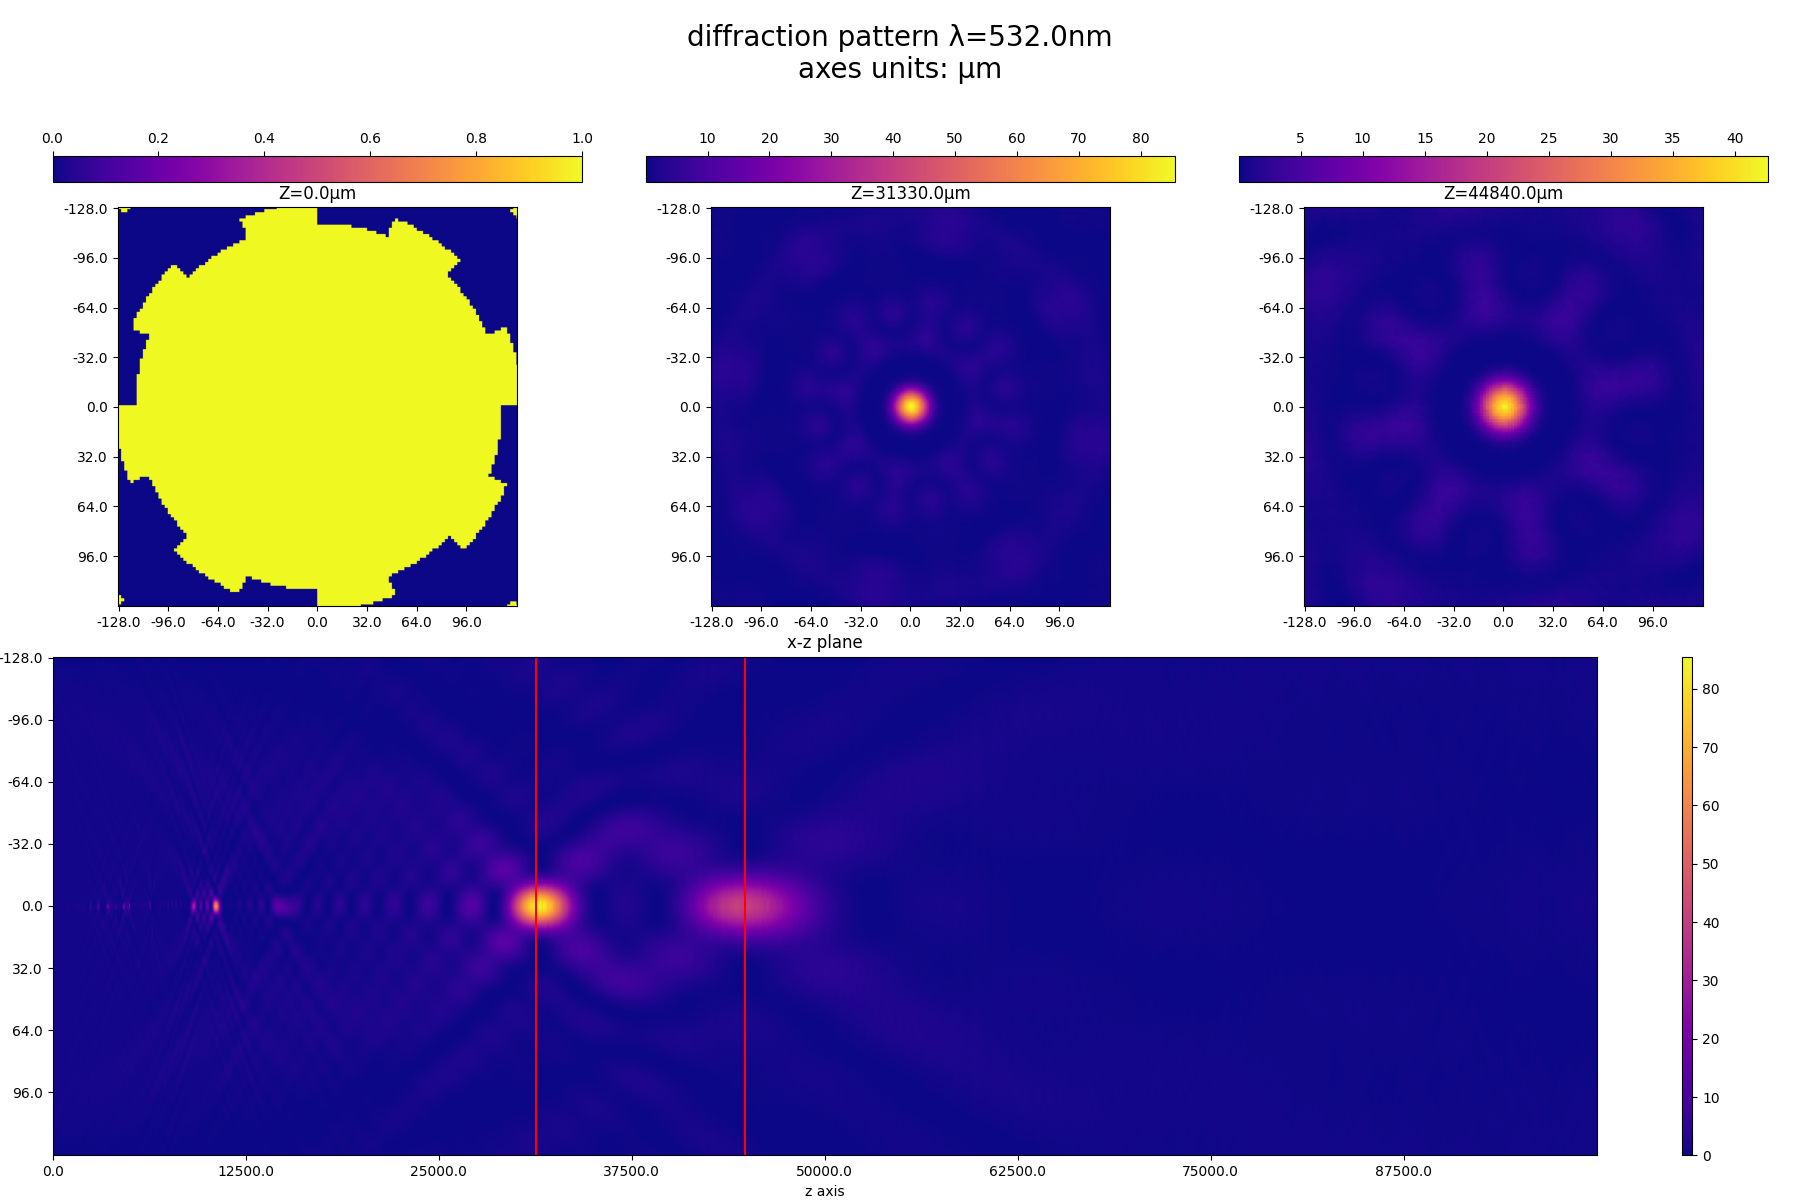

0-th to 10-th highest intensity
[42.681606 42.385952 42.271564 42.268803 42.025455 41.925713 41.86939
 41.667046 41.58392  41.576122]
at
[44840. 44850. 44250. 44640. 45000. 44830. 44330. 44320. 44860. 44970.] μm
index
[4484 4485 4425 4464 4500 4483 4433 4432 4486 4497]


In [16]:
# x, y plot at different zs
E2_max = E2.max(axis=(0, 1)) # Nz # find peak intensity
s = 3750
order = np.flip(np.argsort(E2_max[s:])) + s
focal_z_idx = order[0]
layout = [[0, 1, 2], [3,3,3]]
plot_z_idxs = [0, 3133, focal_z_idx]
E2_plot = [E2[:, :, plot_z_idxs[0]], E2[:, :, plot_z_idxs[1]], E2[:, :, plot_z_idxs[2]]]
# plt.clf()
fig, ax = plt.subplot_mosaic(layout, figsize=(18,12))
fig.suptitle(f'diffraction pattern λ={λ*1e3}nm\naxes units: μm', fontsize=20)
fig.tight_layout(pad=1.5)
for i in range(len(plot_z_idxs)):
    tmp = ax[i].imshow(E2_plot[i].T, aspect='equal', cmap='plasma')
    ax[i].set_xticks(x_ticks, xs[x_ticks])
    ax[i].set_yticks(y_ticks, ys[y_ticks])
    ax[i].set_title(f'Z={zs[plot_z_idxs[i]]}μm')
    fig.colorbar(tmp, ax=[ax[i]], location='top')
# ax[3].set_title(f'focus zoom view, central intensity: {E2[:, :, plot_z_idxs[3]].max():.2f}')
#fig.colorbar(imgC, ax=ax_dict['C'], location='right')
#plt.show()

ax[3].set_title('x-z plane')
tmp = ax[3].imshow(E2[:, Ny//2, :], aspect='auto', cmap='plasma')
ax[3].set_xticks(z_ticks, zs[z_ticks])
ax[3].set_yticks(x_ticks, xs[x_ticks])
ax[3].axvline(x=plot_z_idxs[1], color='r')
ax[3].axvline(x=plot_z_idxs[2], color='r')
ax[3].set_xlabel('z axis')
ax[3].set_ylabel('x axis')
fig.colorbar(tmp, ax=[ax[3]], location='right', fraction=0.05, aspect=50)
#plt.tight_layout()
plt.savefig(f'{save_path}/diffraction.png', bbox_inches='tight')
plt.show()
s, e = 0, 10
print(f'{s}-th to {e}-th highest intensity\n{E2_max[order][s:e]}\nat\n{zs[order][s:e]} μm\nindex\n{order[s:e]}')

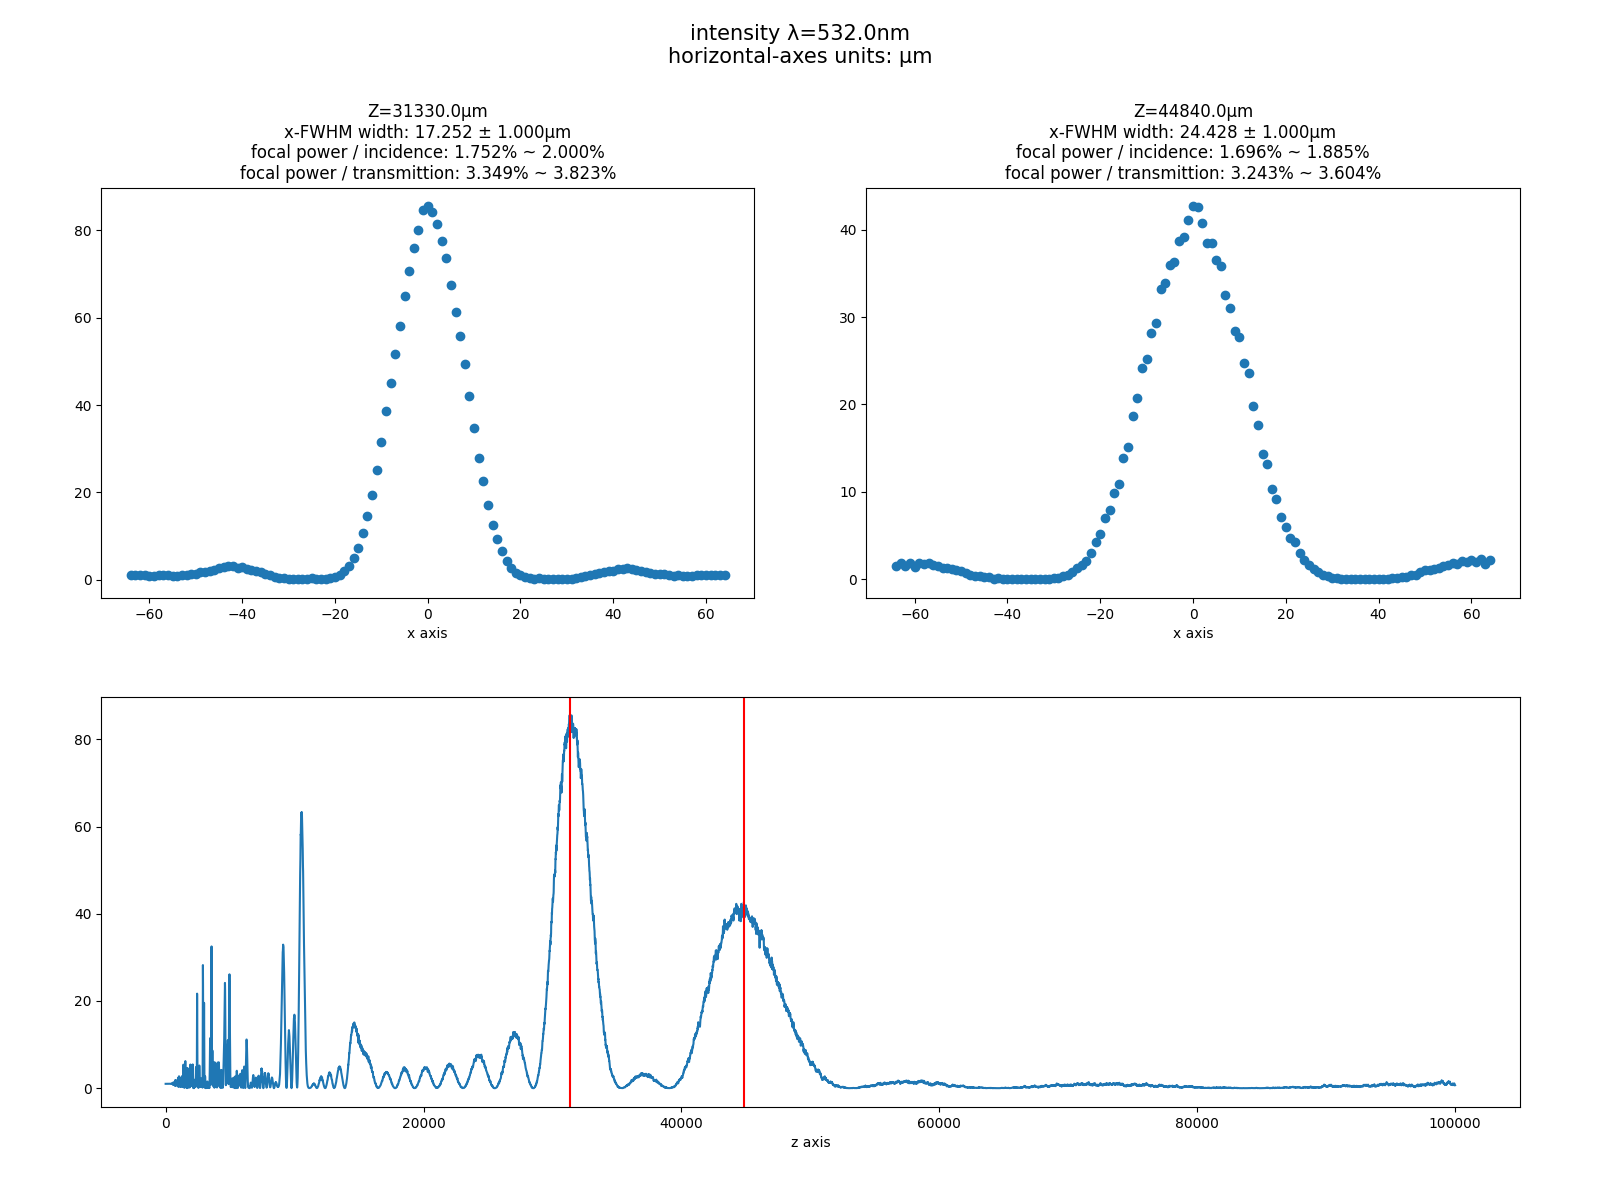

In [17]:
# analysis of focus
# z_idx = order[0]
z_idx1 = plot_z_idxs[1]
z_idx2 = plot_z_idxs[2]
transmitted_power = A_xy.sum() * Δx * Δy
incidence_power = 500**2*π # 500μm^2 * π *1 W/μm^2
section_E2_x1 = E2[:, Ny//2, z_idx1]
FWHM_width_x1 = mt.FWHM(section_E2_x1, xs)
lower_bound_power1, upper_bound_power1, lower_bound_zone1, upper_bound_zone1 = mt.FWHM_power(E2[:, :, z_idx1], Δx, Δy)

section_E2_x2 = E2[:, Ny//2, z_idx2]
FWHM_width_x2 = mt.FWHM(section_E2_x2, xs)
lower_bound_power2, upper_bound_power2, lower_bound_zone2, upper_bound_zone2 = mt.FWHM_power(E2[:, :, z_idx2], Δx, Δy)
plt.clf()
layout = [[0, 1], [2, 2]]
fig, ax = plt.subplot_mosaic(layout, figsize=(16,12))
fig.suptitle(f'intensity λ={λ*1e3}nm\nhorizontal-axes units: μm', fontsize=15)
fig.tight_layout(pad=5)
x_idx_span = 64
x_idx = Nx//2
ax[0].scatter(xs[x_idx - x_idx_span: x_idx + x_idx_span + 1], section_E2_x1[x_idx - x_idx_span: x_idx + x_idx_span + 1])# x axis
ax[0].set_title(f'Z={zs[z_idx1]}μm\nx-FWHM width: {FWHM_width_x1:.3f} ± {(xs[1]-xs[0]):.3f}μm\nfocal power / incidence: {lower_bound_power1/incidence_power*100:.3f}% ~ {upper_bound_power1/incidence_power*100:.3f}%\nfocal power / transmittion: {lower_bound_power1/transmitted_power*100:.3f}% ~ {upper_bound_power1/transmitted_power*100:.3f}%')
ax[0].set_xlabel('x axis')

ax[1].scatter(xs[x_idx - x_idx_span: x_idx + x_idx_span + 1], section_E2_x2[x_idx - x_idx_span: x_idx + x_idx_span + 1])# x axis
ax[1].set_title(f'Z={zs[z_idx2]}μm\nx-FWHM width: {FWHM_width_x2:.3f} ± {(xs[1]-xs[0]):.3f}μm\nfocal power / incidence: {lower_bound_power2/incidence_power*100:.3f}% ~ {upper_bound_power2/incidence_power*100:.3f}%\nfocal power / transmittion: {lower_bound_power2/transmitted_power*100:.3f}% ~ {upper_bound_power2/transmitted_power*100:.3f}%')
ax[1].set_xlabel('x axis')

ax[2].plot(zs, E2[Nx//2, Ny//2, :])# z axis
ax[2].set_xlabel('z axis')
ax[2].axvline(x=zs[plot_z_idxs[1]], color='r')
ax[2].axvline(x=zs[plot_z_idxs[2]], color='r')
plt.savefig(f'{save_path}/focal.png')
plt.show()

In [10]:
lower_bound_zone1.sum()

np.int64(225)

In [11]:
print(A_xy.sum())

410816


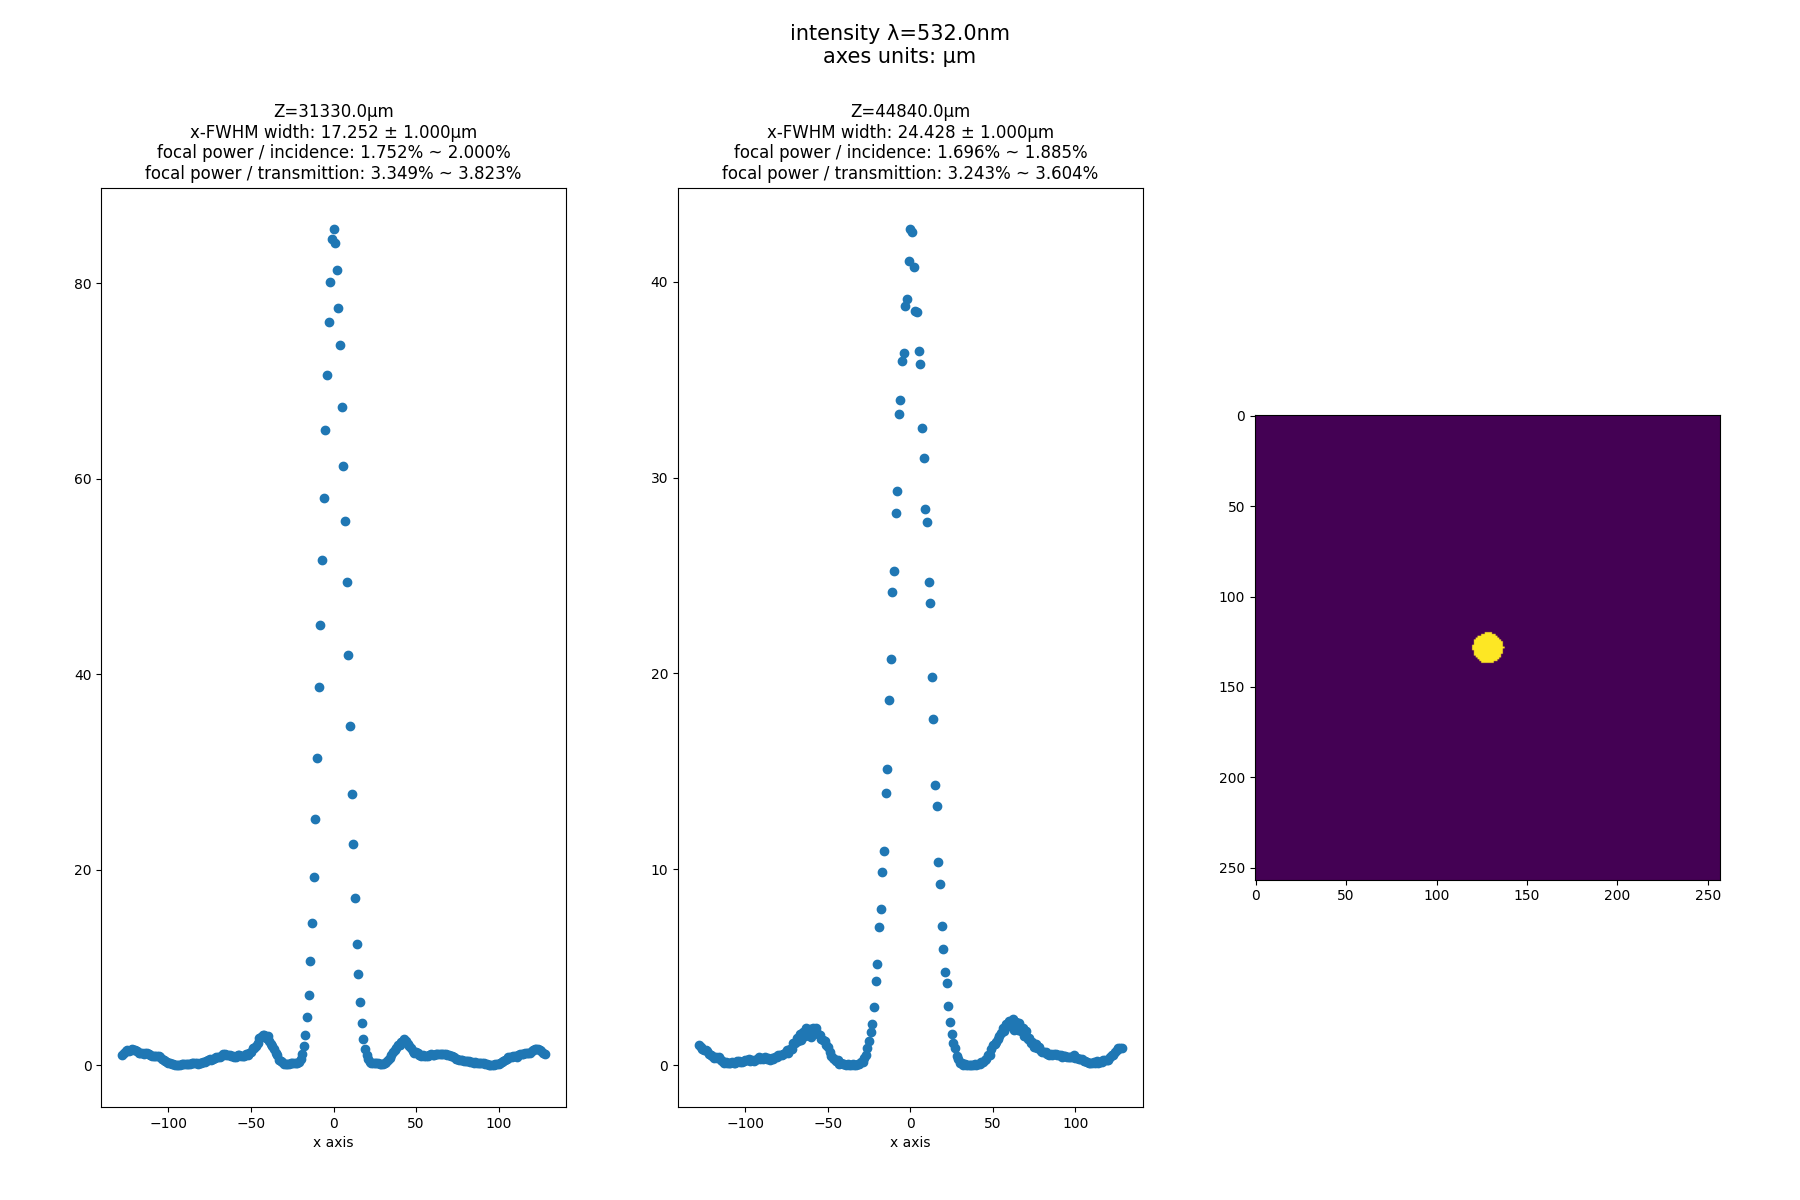

In [9]:
plt.cla()
plt.imshow(lower_bound_zone1)
plt.show()

In [13]:
it.arr_2_mp4(np.moveaxis(E2, -1, 0), path=f'{save_path}/E2.mp4', fps=60, title=lambda z_idx: f'z: {zs[z_idx]}μm')

animation_duration: 83.33333333333333s, fps: 60
